In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import numpy as np
from shapeintegrals_fast_modified_for_hetGP import ShapeIntegral
import GPy
from scipy.stats import multinomial
from scipy.linalg.blas import dtrmm
from GPy.util import choleskies
from GPy.core.parameterization.param import Param
from GPy.kern import Coregionalize
from GPy.likelihoods import Likelihood
from GPy.util import linalg
import random
from HetMOGP.likelihoods.gaussian import Gaussian
from HetMOGP.likelihoods.categorical import Categorical
from HetMOGP.het_likelihood import HetLikelihood
from HetMOGP import util
from HetMOGP.svmogp import SVMOGP

from shapeintegrals_fast_modified_for_hetGP import ShapeIntegral


X1 = np.array([[0,5,0],[5,10,0],[10,15,0],[15,20,0],[30,35,0],[35,40,0]])*1.0
X2 = np.full([10,X1.shape[1]],np.NaN)
#X2[:,0] = np.array([3,4,5,6,7,8,9])+0.5
X2[:,0] = np.array([0,2,4,6,8,10,12,14,16,18])
X2[:,-1] = 1
Y1 = np.array([[50,30,20,50,70,30]]).T*1.0
Y2 = np.array([[5,5,5,3,3,3,2,2,5,5]]).T

X = [X1,X2]
Y = [Y1,Y2]
Z = np.full([20,X1.shape[1]],np.NaN)
Z[:,0:1] = np.linspace(1,19,20)[:,None] #np.random.rand(20,1)*20
Z[:,-1]=1
#kern = GPy.kern.RBF(2, lengthscale=10.0, variance = 1.0, ARD=False)
#oldshapek = ShapeIntegral(X1.shape[1],input_space_dim=2,Nperunit=5,kernel=kern)

In [2]:
X2,Y2

(array([[ 0., nan,  1.],
        [ 2., nan,  1.],
        [ 4., nan,  1.],
        [ 6., nan,  1.],
        [ 8., nan,  1.],
        [10., nan,  1.],
        [12., nan,  1.],
        [14., nan,  1.],
        [16., nan,  1.],
        [18., nan,  1.]]), array([[5],
        [5],
        [5],
        [3],
        [3],
        [3],
        [2],
        [2],
        [5],
        [5]]))

In [3]:
Z

array([[ 1.        ,         nan,  1.        ],
       [ 1.94736842,         nan,  1.        ],
       [ 2.89473684,         nan,  1.        ],
       [ 3.84210526,         nan,  1.        ],
       [ 4.78947368,         nan,  1.        ],
       [ 5.73684211,         nan,  1.        ],
       [ 6.68421053,         nan,  1.        ],
       [ 7.63157895,         nan,  1.        ],
       [ 8.57894737,         nan,  1.        ],
       [ 9.52631579,         nan,  1.        ],
       [10.47368421,         nan,  1.        ],
       [11.42105263,         nan,  1.        ],
       [12.36842105,         nan,  1.        ],
       [13.31578947,         nan,  1.        ],
       [14.26315789,         nan,  1.        ],
       [15.21052632,         nan,  1.        ],
       [16.15789474,         nan,  1.        ],
       [17.10526316,         nan,  1.        ],
       [18.05263158,         nan,  1.        ],
       [19.        ,         nan,  1.        ]])

In [4]:
gpymodel = GPy.models.GPRegression(np.r_[X1,X2],np.r_[Y1,Y2],ShapeIntegral(3,1,kernel=GPy.kern.RBF(1,lengthscale=1,variance=1000),Nperunit=5))
gpymodel.kern.lengthscale.fix(1)
gpymodel.kern.variance.fix(100)
gpymodel.Gaussian_noise.fix(0.01)
gpymodel.optimize()

 /home/mike/Documents/Research/hetMOGPintegral/hetGPIntegralexperiments/shapeintegrals_fast_modified_for_hetGP.py:93: RuntimeWarning:divide by zero encountered in true_divide


nothing to optimize


In [5]:
gpymodel

GP_regression.,value,constraints,priors
shapeintegral.variance,100.0,+ve fixed,
shapeintegral.lengthscale,1.0,+ve fixed,
Gaussian_noise.variance,0.01,+ve fixed,


In [10]:
X1

array([[ 0.,  5.,  0.],
       [ 5., 10.,  0.],
       [10., 15.,  0.],
       [15., 20.,  0.],
       [30., 35.,  0.],
       [35., 40.,  0.]])

In [16]:
testX = np.full([100,3],np.NaN)
testX[:,0] = np.linspace(0,40,100)
testX[:,2] = 1.0

predmean, predvar = gpymodel.predict(testX)

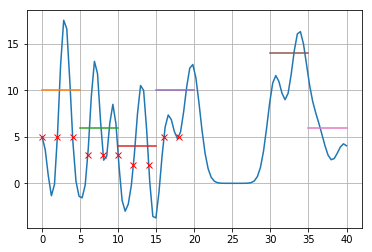

In [17]:
plt.plot(testX[:,0],predmean)
plt.plot(X2[:,0],Y2[:,0],'xr')
for x,y in zip(X1,Y1):
    l = x[1]-x[0]
    plt.plot([x[0],x[1]],[y[0]/l,y[0]/l])
plt.grid()

In [171]:
likelihoods_list = [Gaussian(sigma=0.01), Gaussian(sigma=0.01)]
likelihood = HetLikelihood(likelihoods_list)
Y_metadata = likelihood.generate_metadata()

D = likelihood.num_output_functions(Y_metadata)
Q = 1
W_list, _ = util.random_W_kappas(Q, D, rank=1, experiment=True)

kern_list=[ShapeIntegral(X[0].shape[1],1,kernel=GPy.kern.RBF(1,lengthscale=1,variance=10),Nperunit=5)]

model = SVMOGP(X=X, Y=Y, Z=Z, kern_list=kern_list, likelihood=likelihood, Y_metadata=Y_metadata)

 /home/mike/anaconda3/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log
 /home/mike/Documents/Research/hetMOGPintegral/hetGPIntegralexperiments/shapeintegrals_fast_modified_for_hetGP.py:93: RuntimeWarning:divide by zero encountered in true_divide


In [172]:
from HetMOGP.util import vem_algorithm as VEM
model.shapeintegral.variance.fix(10)
model.shapeintegral.lengthscale.fix(1)
model=VEM(model,vem_iters=3,maxIter_perVEM=4,optZ=False,verbose=True,verbose_plot=False,non_chained=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i   f              |g|        
    00s00  0   6.148917e+07           nan 

 /home/mike/anaconda3/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


    02s27  2   6.059880e+07   7.804458e+11 
    06s40  6   3.077265e+07   6.781682e+09 
Runtime:     06s40
Optimization status: Maximum number of f evaluations reached

iteration (1) VE step, log_likelihood=[-30772654.22275073]
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i   f              |g|        
    01s10  1   3.077265e+07   1.070245e+14 
    05s89  6   3.024716e+07   3.709539e+13 
Runtime:     05s89
Optimization status: Maximum number of f evaluations reached

iteration (1) VM step, log_likelihood=[-30247156.07473927]
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i   f              |g|        
    00s00  0   3.024716e+07   3.709539e+13 
    05s47  6   2.933781e+07   1.359959e+09 
Runtime:     05s47
Optimization status: Maximum number of f evaluations reached

iteration (2) VE step, log_likelihood=[-29337812.98122419]
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i   f              |g|        
    03s50  4   2.932753e+07   2.711999e+12 
    0

In [173]:
model.shapeintegral.kernel

rbf.,value,constraints,priors
variance,10.004578562002374,+ve,
lengthscale,1.0289982723895286,+ve,


In [174]:
model

SVMOGP.,value,constraints,priors
inducing inputs,"(20, 3)",fixed,
m_u,"(20, 1)",fixed,
L_u,"(210, 1)",fixed,
shapeintegral.variance,10.004578562002374,+ve,
shapeintegral.lengthscale,1.0289982723895286,+ve,
B_q0.W,"(2, 1)",,
B_q0.kappa,"(2,)",+ve fixed,


In [175]:
model.predictive_f_star(X2)

(array([[8.75407413],
        [6.38329387],
        [9.85759552],
        [3.58046258],
        [3.48721839],
        [3.48611365],
        [2.29174505],
        [2.32627475],
        [6.36226951],
        [5.5373279 ]]), array([[0.61695103],
        [0.0028013 ],
        [0.00708133],
        [0.00800707],
        [0.01069292],
        [0.01609952],
        [0.01470527],
        [0.00696721],
        [0.00135207],
        [0.00338072]]))

In [176]:
testX = np.full([100,X1.shape[1]],np.NaN)
testX[:,0] = np.linspace(0,30,100)
testX[:,-1] = 1
predY, varY = model.predictive_f_star(testX)

In [177]:
testX[:,0]

array([ 0.        ,  0.3030303 ,  0.60606061,  0.90909091,  1.21212121,
        1.51515152,  1.81818182,  2.12121212,  2.42424242,  2.72727273,
        3.03030303,  3.33333333,  3.63636364,  3.93939394,  4.24242424,
        4.54545455,  4.84848485,  5.15151515,  5.45454545,  5.75757576,
        6.06060606,  6.36363636,  6.66666667,  6.96969697,  7.27272727,
        7.57575758,  7.87878788,  8.18181818,  8.48484848,  8.78787879,
        9.09090909,  9.39393939,  9.6969697 , 10.        , 10.3030303 ,
       10.60606061, 10.90909091, 11.21212121, 11.51515152, 11.81818182,
       12.12121212, 12.42424242, 12.72727273, 13.03030303, 13.33333333,
       13.63636364, 13.93939394, 14.24242424, 14.54545455, 14.84848485,
       15.15151515, 15.45454545, 15.75757576, 16.06060606, 16.36363636,
       16.66666667, 16.96969697, 17.27272727, 17.57575758, 17.87878788,
       18.18181818, 18.48484848, 18.78787879, 19.09090909, 19.39393939,
       19.6969697 , 20.        , 20.3030303 , 20.60606061, 20.90

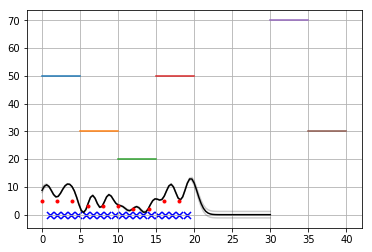

In [178]:
plt.plot(testX[:,0],predY,'-k',alpha=1)
plt.plot(testX[:,0],predY+np.sqrt(varY),'-k',alpha=0.2)
plt.plot(testX[:,0],predY-np.sqrt(varY),'-k',alpha=0.2)
#plt.ylim([-2,5])
plt.grid()
plt.scatter(Z[:,0],np.zeros(len(Z)),50,marker='x',color='b')
plt.plot(X2[:,0],Y2[:,0],'r.')
for x,y in zip(X1,Y1):
    plt.plot([x[0],x[1]],[y[0],y[0]])

In [179]:
model.kern

shapeintegral.,value,constraints,priors
variance,10.004578562002374,+ve,
lengthscale,1.0289982723895286,+ve,


In [163]:
model.B_q0.B

array([[0.22295288, 0.15706537],
       [0.15706537, 0.11064908]])